# OOD detection applied to Hallucination Detection

In [1]:
#/home/lila.roig/.env/ood_env/bin/python

## Part II. Analyze results

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
# -----------------------------------
import torch
import sys
import os 
import numpy as np
import pandas as pd
# Add the path to the src directory
sys.path.append(os.path.abspath(".."))

In [3]:
# Visualize setup 
# -----------------------------------
print(f"Python version: {sys.version}")
print(f"Cuda version: {torch.version.cuda}")
num_gpus = torch.cuda.device_count()
print(f"Number of available de GPU : {num_gpus}")
for i in range(num_gpus):
    print(f"GPU {i + 1} : {torch.cuda.get_device_name(i)}")

Python version: 3.11.13 (main, Jun  4 2025, 08:57:30) [GCC 13.3.0]
Cuda version: 12.6
Number of available de GPU : 1
GPU 1 : NVIDIA GeForce RTX 3080


In [289]:
# Define global variables
# -----------------------------------
SEED = 44
BATCH_SIZE = 16
START_OFFSET = 0  # always 0 for now
END_OFFSET = 0    # always 0 for now

# Extract descriptors from: prompt, generated answer or both concatenated 
ACTIVATION_SOURCE = "prompt"  # 'prompt', 'generation', 'PromptGeneration'

# Define repository names
OUTPUT_DIR = f"../results/raw/small_dataset_allConfig_seed{SEED}/"
PLOT_DIR   = f"../results/figures/small_dataset_allConfig_seed{SEED}/"

# Define file name
STR_AGG = 'All'
STR_LAYERS = '1:32:2'
OUTPUT_TITLE = f"_layer{STR_LAYERS}_agg{STR_AGG}_{ACTIVATION_SOURCE}_so{START_OFFSET}_eo{END_OFFSET}_seed{SEED}"

In [272]:
# Seed everything
# -----------------------------------
from src.utils.general import seed_all
seed_all(SEED)

In [273]:
# Clear memory to avoid "CUDA out of memory"
# -----------------------------------
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

### 1. Load all extracted descriptors (obtained from Part I.)

In [290]:
# Load ID descriptors 
# -----------------------------------
from src.data_reader.pickle_io import load_pickle_batches
from src.utils.general import add_unanswerable_flag, filter_entries

# Load extracted descriptors 
id_fit_data = load_pickle_batches(f"{OUTPUT_DIR}id_fit_results{OUTPUT_TITLE}.pkl")

# Add unanswerable flag: check if the generated answer contains 'unanswerable' keyword
# Expect many 'unanswerable' flags in `od_test_data` and few in `id_test_data`, if model works well
id_fit_data = add_unanswerable_flag(id_fit_data)

# Filter descriptors: keep only answerable answers for ID
if False:  #### TODO: ADAPT TO NEW CODE VERSION ####
    id_fit_data = filter_entries(id_fit_data, column='is_unanswerable', value=0) 

Loaded 7971 samples from: ../results/raw/small_dataset_allConfig_seed44/id_fit_results_layer1:32:2_aggAll_prompt_so0_eo0_seed44.pkl


In [291]:
# Load test descriptors 
# -----------------------------------
from src.data_reader.pickle_io import load_pickle_batches
from src.utils.general import add_unanswerable_flag, filter_entries

# Load extracted possible and impossible descriptors 
od_test_data = load_pickle_batches(f"{OUTPUT_DIR}od_test_results{OUTPUT_TITLE}.pkl")
id_test_data = load_pickle_batches(f"{OUTPUT_DIR}id_test_results{OUTPUT_TITLE}.pkl")

# Add unanswerable flag: check if the generated answer contains 'unanswerable' keyword
# Expect many 'unanswerable' flags in `od_test_data` and few in `id_test_data`, if model works well
od_test_data = add_unanswerable_flag(od_test_data)
id_test_data = add_unanswerable_flag(id_test_data)

# Filter descriptors: keep only unanswerable answers for OOD, and only answerable answers for ID
if False: #### TODO: ADAPT TO NEW CODE VERSION ####
    od_test_data = filter_entries(od_test_data, column='is_unanswerable', value=1)
    id_test_data = filter_entries(id_test_data, column='is_unanswerable', value=0)

Loaded 1000 samples from: ../results/raw/small_dataset_allConfig_seed44/od_test_results_layer1:32:2_aggAll_prompt_so0_eo0_seed44.pkl
Loaded 1000 samples from: ../results/raw/small_dataset_allConfig_seed44/id_test_results_layer1:32:2_aggAll_prompt_so0_eo0_seed44.pkl


In [257]:
# Result DataFrame: Initialization with sample indexes and 'unanswerable' flag
# -----------------------------------
n_id  = len(id_test_data['id'])
n_ood = len(od_test_data['id'])
df_result = pd.DataFrame({
    'set': ['ID'] * n_id + ['OOD'] * n_ood,
    'index': list(range(n_id)) + list(range(n_ood)),
})
df_result['is_unanswerable'] = np.concatenate([
    id_test_data['is_unanswerable'],
    od_test_data['is_unanswerable']
])

### 2. Evaluate one configuration

#### 2.1. Extract one config from result dict

In [276]:
# Visualize all configurations available from loaded descriptors `id_fit_data`
# -----------------------------------
from src.analysis.analyze_ood_results import discover_config_space

space = discover_config_space(id_fit_data)
print(space)

{'layers': [-1, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29], 'hidden_aggs_by_layer': {-1: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 1: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 3: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 5: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 7: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 9: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 11: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 13: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 15: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 17: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 19: ['avg_emb', 'f

In [277]:
# Choose 1 configuration (layer, aggregation group, aggregation mode)
# -----------------------------------
TARGET_LAYER = -1
AGG_GROUP = 'logit'              # logit, attention, hidden

AGG_MODE = 'logit_entropy_score' # perplexity_score, logit_entropy_score, window_logit_entropy_score, 
                                 # attn_score, avg_emb, last_emb, max_emb, first_gen_emb, 
                                 # feat_var_emb, hidden_score

In [278]:
# Select one configuration (layer, group, aggregation) from all the available descriptors
# -----------------------------------
from src.analysis.analyze_ood_results import retrieve_one_config_from_dict

id_fit_descriptors  = retrieve_one_config_from_dict(id_fit_data,  layer=TARGET_LAYER, group=AGG_GROUP, aggregation=AGG_MODE)
id_test_descriptors = retrieve_one_config_from_dict(id_test_data, layer=TARGET_LAYER, group=AGG_GROUP, aggregation=AGG_MODE)
od_test_descriptors = retrieve_one_config_from_dict(od_test_data, layer=TARGET_LAYER, group=AGG_GROUP, aggregation=AGG_MODE)

#### 2.2. Compute OOD scores for the chosen config

In [279]:
# Define OOD methods configs
# -----------------------------------
config_dknn = {'k': 5, 'batch_size': BATCH_SIZE} # DKNN config
config_cosine = {'center_type':'all', 'seed': SEED, 'k': 5, 'batch_size': BATCH_SIZE} # Cosine Similarity config
config_maha = {'center_type':'mean', 'seed': SEED, 'k': 5} # Mahalanobis config
config_ocsvm = {'kernel':'rbf', 'nu': 0.1, 'gamma': 'scale'} # OCSVM config
config_isoforest = {'n_estimators':1000, 'contamination': 'auto', 'seed': SEED} # Isolation forest config

In [280]:
# Compute OOD scores:
# If the descriptors are embeddings (2D tensors):
#   - Compute OOD scores using OOD detection methods
#   - Choose `method` in {'dknn', 'cosine', 'mahalanobis', 'ocsvm', 'isoforest'} with matching config
# If the descriptros are already 1D scores:
#   - Use them directly as OOD scores; do not apply OOD methods 
#   - Choose `method='raw_scores'` ;  config is ignored.
# -----------------------------------
from src.ood_methods.ood_main import compute_ood_scores

# **Convention**: high OOD score => OOD data ; low OOD score => ID data
scores_id, scores_ood = compute_ood_scores(
    method='raw_scores',
    id_fit_descriptors=id_fit_descriptors,
    id_test_descriptors=id_test_descriptors,
    od_test_descriptors=od_test_descriptors,
    **config_dknn
)
print("Mean of ID scores:", np.mean(scores_id))
print("Mean of OOD scores:", np.mean(scores_ood))


# Result DataFrame: Add ood scores
# -----------------------------------
df_result['ood_score'] = np.concatenate([scores_id, scores_ood])

Mean of ID scores: 0.20531280556303683
Mean of OOD scores: 0.26440482059819626


#### 2.3. Evaluate OOD scores (unsupervised)

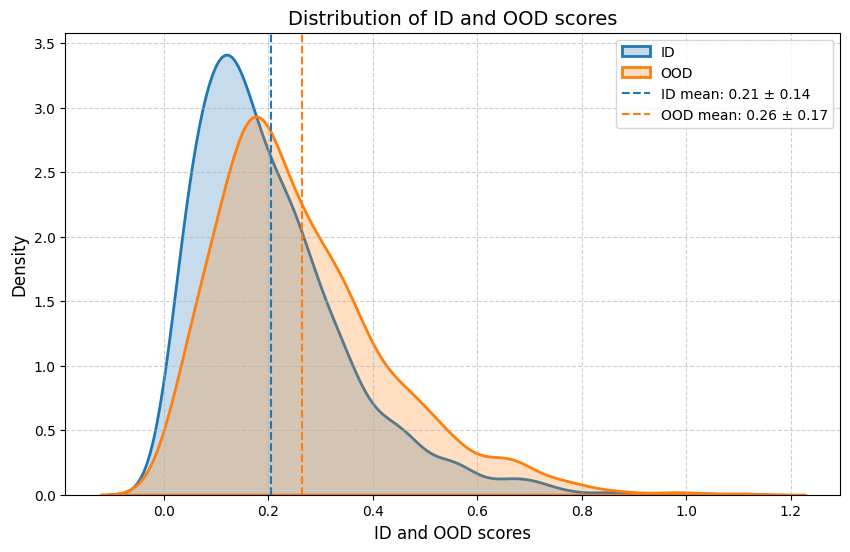

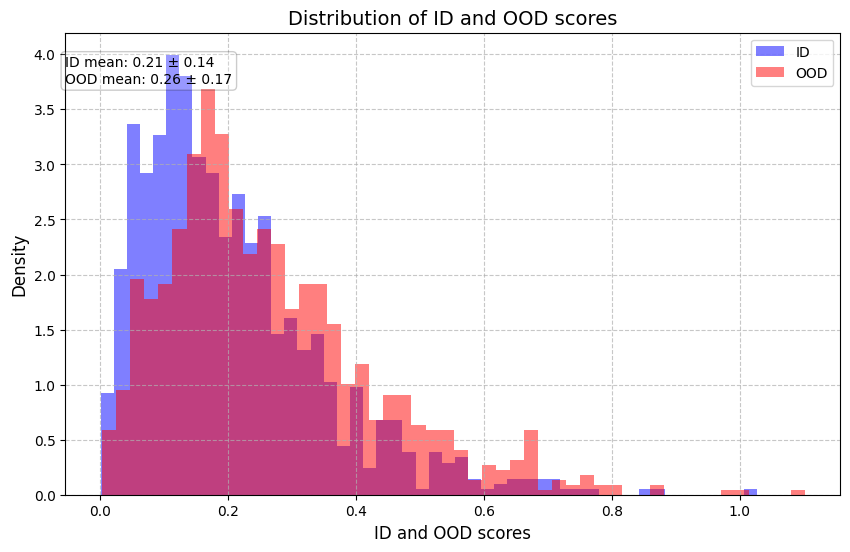

In [281]:
# Plot ID and OOD score distributions 
# -----------------------------------
from src.analysis.visualization import plot_score_distributions_kde, plot_score_distributions_hist
plot_score_distributions_kde(
    scores_id=scores_id,
    scores_ood=scores_ood,
    title="Distribution of ID and OOD scores",
    xlabel="ID and OOD scores"
    #save_path = f"{PLOT_DIR}densities{OUTPUT_TITLE}_k{k}.png"
)

plot_score_distributions_hist(
    scores_id=scores_id,
    scores_ood=scores_ood,
    title="Distribution of ID and OOD scores",
    xlabel="ID and OOD scores"
    #save_path = f"{PLOT_DIR}densities{OUTPUT_TITLE}_k{k}.png"
)

auROC: 0.6158
FPR95: 0.8940
AUC-PR: 0.5980
Optimal Threshold (youden): 0.1471


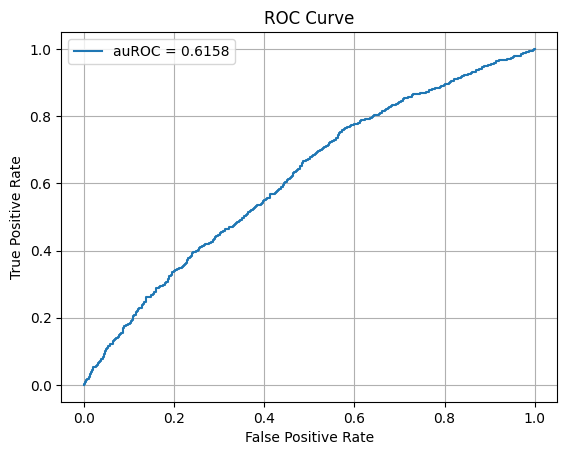

In [285]:
# Compute and plot auroc 
# -----------------------------------
from src.analysis.evaluation import compute_metrics
auroc, fpr95, auc_pr, fpr, tpr, thresholds, selected_threshold = compute_metrics(
    scores_id=scores_id, 
    scores_ood=scores_ood, 
    plot=True,
    threshold_strategy='youden', # 'youden', 'target_tpr'
    target_tpr = 0.95,
    #save_path= f"{PLOT_DIR}roc{OUTPUT_TITLE}_k{k}.png"
)

ᓚ₍ ^. ̫ .^₎

Accuracy: 0.5925
F1 score: 0.6501
Precision: 0.5696
Recall: 0.7570


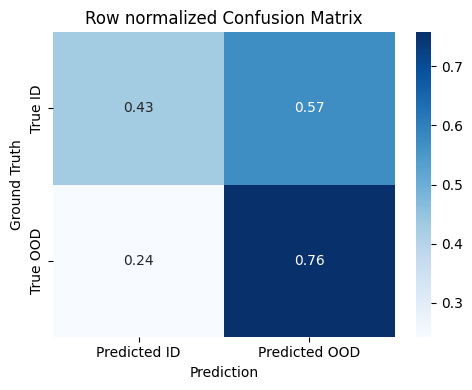

In [286]:
# Generate labels for each test point => 2 possible labels 
# Predicted class is assigned as follows:
#    - score >  threshold -> predicted OOD (label 1)
#    - score <= threshold -> predicted ID (label 0)
# -----------------------------------
# Ground-truth labels: 0=ID, 1=OOD
y_true_thresh = np.concatenate((
    np.zeros(len(scores_id)),
    np.ones(len(scores_ood))
))
# Predicted labels based on threshold: 0=ID, 1=OOD
y_pred_thresh = np.concatenate((
    (scores_id  > selected_threshold).astype(int), 
    (scores_ood > selected_threshold).astype(int)
))

# Result DataFrame: Add 2 class labels (based on Youden's threshold)
# -----------------------------------
df_result['label_2class'] = y_pred_thresh

# Compute confusion matrix
# -----------------------------------
from src.analysis.evaluation import compute_confusion_matrix_and_metrics
cm, accuracy, f1, precision, recall = compute_confusion_matrix_and_metrics(
    y_true=y_true_thresh,
    y_pred=y_pred_thresh,
    plot= True,
    normalize=True,
)

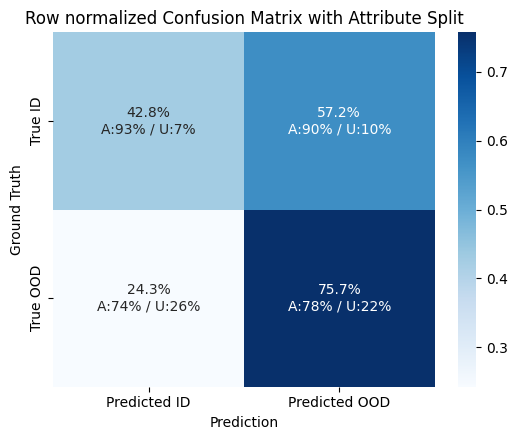

In [287]:
# Plot confusion matrix with unanswerable/answerable split
# -----------------------------------
from src.analysis.evaluation import compute_confusion_matrix_with_attribute_split

compute_confusion_matrix_with_attribute_split(
    y_true=y_true_thresh,
    y_pred=y_pred_thresh,
    attribute=df_result["is_unanswerable"].values,
    attr_labels=("A", "U"), 
    attr_true_value=True,
    normalize=True 
)
# cm_prompt_layer13_last_emb_dknn5_youden_seed777
# cm_generation_layer-1_logit_entropy_dknn5_youden_seed2025
# targetTPR    youden

#### 2.4. Linear Probing on OOD scores (supervised)

Accuracy: 0.7800
F1 score: 0.7905
Precision: 0.7545
Recall: 0.8300


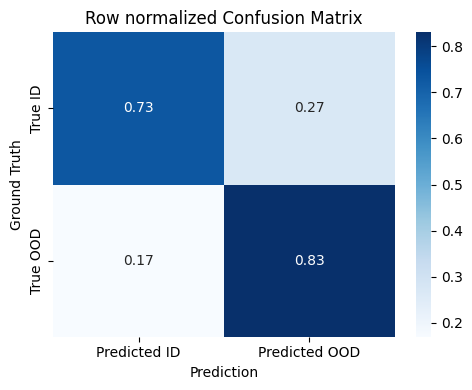

In [55]:
# Perform logistic regression 
# -----------------------------------
from src.analysis.evaluation import compute_confusion_matrix_and_metrics
from src.ood_methods.logistic_regression import train_logistic_regression_on_descriptors
from src.analysis.analyze_ood_results import ensure_2d

clf, y_true_probe, y_pred_probe, idx_test = train_logistic_regression_on_descriptors(
    ensure_2d(id_test_descriptors), ensure_2d(od_test_descriptors), random_state=SEED, test_size=0.1
)
cm, accuracy, f1, precision, recall = compute_confusion_matrix_and_metrics(
    y_true=y_true_probe,
    y_pred=y_pred_probe,
    plot=True,
    normalize=True,
) 

# Result DataFrame: Add labels predicted by logistic regression
# -----------------------------------
df_result['label_probing'] = np.nan  # init with NaN
df_result.loc[idx_test, 'label_probing'] = y_pred_probe.astype(int)

### 3. Visualize one configuration

In [28]:
# Plot PCA, t-SNE and UMAP of unclassified samples  
# NOTE: only available for 2D embedding descriptors (will produce error for 1D descriptors)
# -----------------------------------
from src.analysis.visualization import plot_dim_reduction_3d_embeddings

pca_config = {'n_components': 3}
tsne_config = {'n_components': 3, 'perplexity': 50}
umap_config = {'n_components': 3, 'n_neighbors': 15, 'min_dist': 0.1}

# --- PCA only ---
_ = plot_dim_reduction_3d_embeddings(
    id_test_embeddings=id_test_descriptors, #[N,D]
    od_test_embeddings=od_test_descriptors, 
    labels_id=None, 
    labels_ood=None,
    pca_config=pca_config
)

# --- t-SNE only ---
'''
_ = plot_dim_reduction_3d_embeddings(
    id_test_embeddings=id_test_descriptors, 
    od_test_embeddings=od_test_descriptors, 
    labels_id=None, 
    labels_ood=None,
    tsne_config=tsne_config
)

# --- UMAP only ---
_ = plot_dim_reduction_3d_embeddings(
    id_test_embeddings=id_test_descriptors, 
    od_test_embeddings=od_test_descriptors, 
    labels_id=None, 
    labels_ood=None,
    umap_config=umap_config
)
'''

'\n_ = plot_dim_reduction_3d_embeddings(\n    id_test_embeddings=id_test_descriptors, \n    od_test_embeddings=od_test_descriptors, \n    labels_id=None, \n    labels_ood=None,\n    tsne_config=tsne_config\n)\n\n# --- UMAP only ---\n_ = plot_dim_reduction_3d_embeddings(\n    id_test_embeddings=id_test_descriptors, \n    od_test_embeddings=od_test_descriptors, \n    labels_id=None, \n    labels_ood=None,\n    umap_config=umap_config\n)\n'

In [29]:
# Generate labels for each test point => 4 possible labels 
# -----------------------------------
'''
Class 0: ID well classified  (true ID,  score < threshold)
Class 1: OOD well classified (true OOD, score > threshold)
Class 2: OOD not detected    (true OOD, score < threshold)
Class 3: ID not detected     (true ID,  score > threshold)
'''
# Assumes that : Low score => ID, High score => OOD
labels_id_thresh  = np.where(scores_id  < selected_threshold, 0, 3)   # 0: ID correct, 3: ID not detected
labels_ood_thresh = np.where(scores_ood > selected_threshold, 1, 2)   # 1: OOD correct, 2: OOD not detected

# Result DataFrame: Add 4 class labels (well/wrongly classified)
# -----------------------------------
df_result['label_4class'] = np.concatenate([labels_id_thresh, labels_ood_thresh])

In [30]:
# Plot PCA, t-SNE and UMAP of classified samples  
# NOTE: only available for 2D embedding descriptors (will produce error for 1D descriptors)
# -----------------------------------
from src.analysis.visualization import plot_dim_reduction_3d_embeddings

pca_config = {'n_components': 3}
tsne_config = {'n_components': 3, 'perplexity': 100}
umap_config = {'n_components': 3, 'n_neighbors': 15, 'min_dist': 0.1}

# --- PCA only ---
_ = plot_dim_reduction_3d_embeddings(
    id_test_embeddings=id_test_descriptors, 
    od_test_embeddings=od_test_descriptors, 
    labels_id=labels_id_thresh, 
    labels_ood=labels_ood_thresh, 
    pca_config=pca_config
)

### 4. Test all possible config

In [8]:
# Evaluate all available (layer, group, aggregation) configurations using the chosen OOD method.
# -----------------------------------
from src.analysis.analyze_ood_results import grid_search_best_config

df_res = grid_search_best_config(
    id_fit_data=id_fit_data,
    id_test_data=id_test_data,
    od_test_data=od_test_data,
    method="dknn", # "dknn", "cosine", "mahalanobis", "ocsvm", "isoforest" --> DO NOT PUT "raw_scores" (managed internally)
    method_params=config_dknn,
    probing_test_size=0.1,
    probing_random_state=SEED,
    show_progress=True,
    save_path=PLOT_DIR + f'ood_grid_{ACTIVATION_SOURCE}_seed{SEED}.xlsx',
    threshold_strategy='target_tpr', # 'youden', 'target_tpr'
    target_tpr= 0.95,
    sort_by=['auroc','acc_probe'],
    ascending=None,
    debug=False
)

Layers:   0%|          | 0/16 [00:00<?, ?it/s]

Layers: 100%|██████████| 16/16 [04:49<00:00, 18.07s/it]


In [68]:
# Average/std all available (layer, group, aggregation) configurations from different seeds
# -----------------------------------
from src.analysis.analyze_ood_results import average_ood_grid_results

ACTIVATION_SOURCE = 'promptGeneration'
seeds = [42, 44, 123, 777, 2025]
paths = [f"../results/figures/small_dataset_allConfig_seed{s}/" +
          f'ood_grid_{ACTIVATION_SOURCE}_seed{s}.xlsx' for s in seeds]

res = average_ood_grid_results(
    paths=paths,
    round_digits=4,
    sort_by=None,
    ascending=None,
    save_path=f'../results/figures/ood_grid_{ACTIVATION_SOURCE}_Allseed.xlsx',
    readable_writing=True,
) 

### Bootstrap analysis: determine optimal number of samples for best result

In [27]:
# ===================================
# Perform bootstrap analysis to determine the optimal 
# number of samples to obtain the best result
# ===================================
from src.analysis.bootstrap import bootstrap_analysis

# Define sample size ranges to be tested
# -----------------------------------
n_fit_samples_range = [10_000, 20_000, 40_000, 60_000, 70_000, 80_000]
n_test_samples_range = [1_000, 2_000, 4_000, 7_000, 8_000]

# Compute bootstrap analysis
# -----------------------------------
bootstrap_results = bootstrap_analysis(
    id_fit_embeddings=id_fit_descriptors,
    id_test_embeddings=id_test_descriptors,
    od_test_embeddings=od_test_descriptors,
    n_fit_samples=n_fit_samples_range,
    n_test_samples=n_test_samples_range,
    compute_ood_score_fn=compute_dknn_scores, ### TODO: MUST BE ADAPTED TO NEW CODE VERSION
    n_bootstrap=50, 
    **config
)


Starting bootstrap analysis...


Fit samples:   0%|          | 0/6 [00:00<?, ?it/s]

Fit samples: 100%|██████████| 6/6 [36:36<00:00, 366.05s/it]


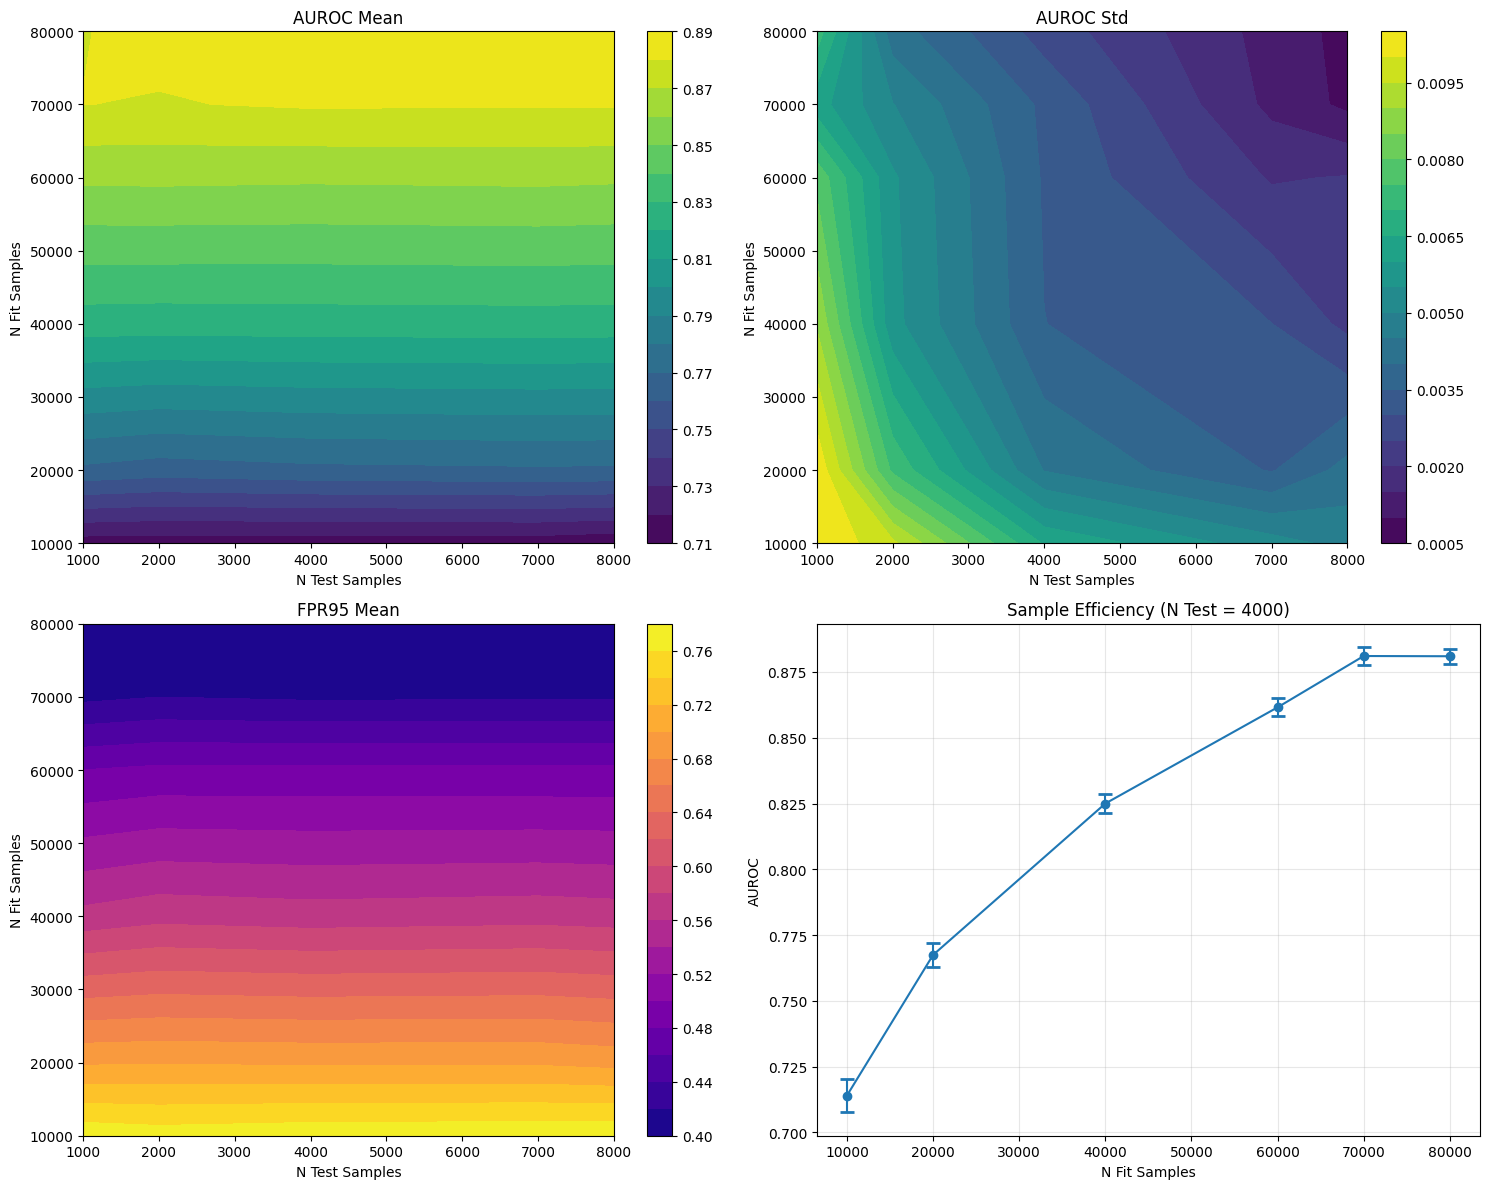


FINAL RESULTS

Bootstrap Analysis (averages over 6×5 configurations):
AUROC: 0.822 ± 0.005
AUPRC: 0.798 ± 0.006
FPR95: 0.560 ± 0.014

RECOMMENDATIONS

Optimal configuration found:
  - Fit samples: 80000
  - Test samples: 2000
  - AUROC: 0.882 ± 0.004

Saturation analysis:
  - With 10000 fit samples: AUROC = 0.822
  - With 80000 fit samples: AUROC = 0.821


In [29]:
# Visualize bootstrap analysis
# -----------------------------------
from src.analysis.bootstrap import plot_bootstrap_results, display_bootstrap_statistics

plot_bootstrap_results(bootstrap_results, save_path=f"{PLOT_DIR}bootstrap_analysis{OUTPUT_TITLE}.png")

display_bootstrap_statistics(bootstrap_results, n_fit_samples_range, n_test_samples_range)

### 6. Trajectories

#### 6.1. Scalar trajectories

Analyse trajectories from 1D scores: `logit_entropy_score`, `window_logit_entropy_score`, `perplexity_score`, `attn_score`, `hidden_score`

In [38]:
# Extract 1D scores trajectories (logit_entropy_score, window_logit_entropy_score,
# perplexity_score, attn_score, hidden_score)
# -----------------------------------
from src.trajectories.trajectories import collect_layerwise_series

layers = list(range(1, 31, 2)) + [-1]

scalar_series = collect_layerwise_series(
    layers=layers,
    id_fit_data=id_fit_data,
    id_test_data=id_test_data,
    od_test_data=od_test_data,
    group='logit',
    aggregation='logit_entropy' + '_score', 
)

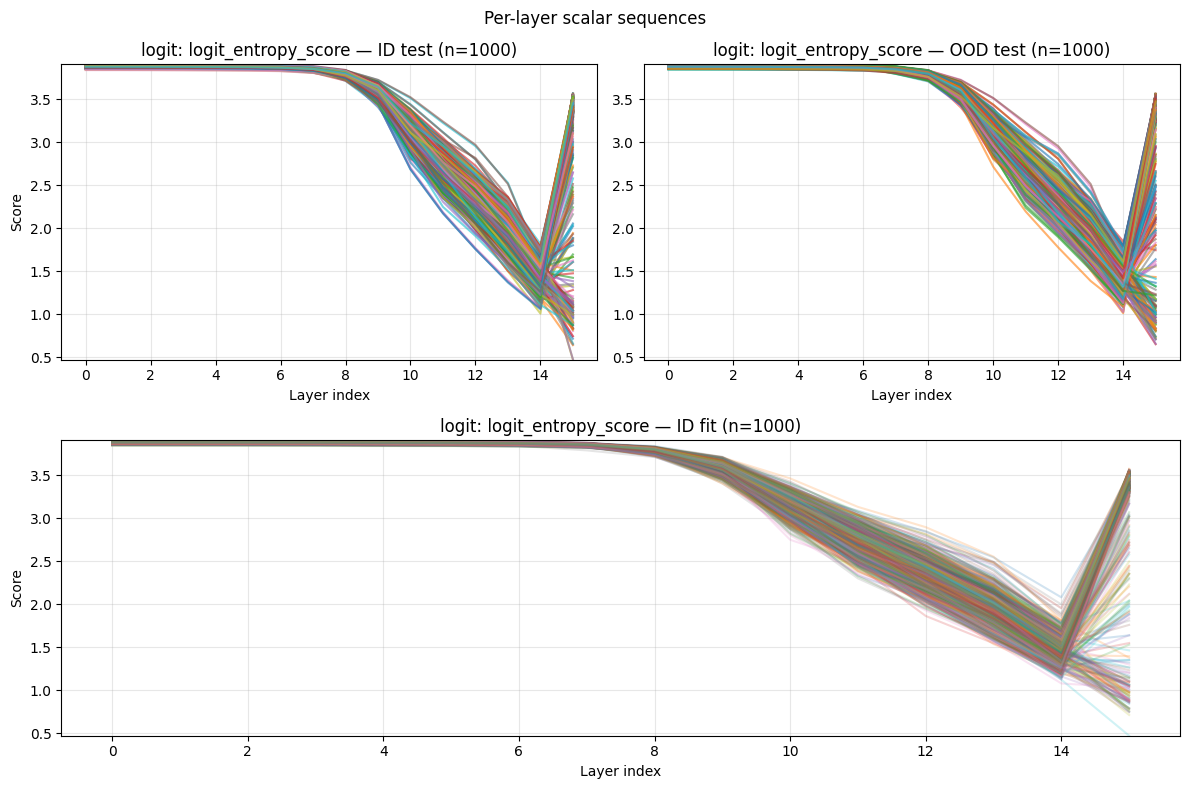

In [39]:
# Visualize 1D scores trajectories 
# -----------------------------------
from src.trajectories.trajectories import plot_layerwise_scalar_series

plot_layerwise_scalar_series(scalar_series, idx=range(0, 1000), fit_max=1000)

**METHOD 1**: Dimension joint volatility of 1D trajectories

In [40]:
# METHOD 1: Compute dimension joint volatility of 1D trajectories
# ----------------------------------
from src.trajectories.trajectories import compute_dimension_joint_volatility_1D

scores_id  = - compute_dimension_joint_volatility_1D(scalar_series['id_test'])  ### /.\ I put minus
scores_ood = - compute_dimension_joint_volatility_1D(scalar_series['od_test'])  ### /.\ I put minus

print("Mean of ID scores:", np.mean(scores_id))
print("Mean of OOD scores:", np.mean(scores_ood))

Mean of ID scores: -0.2836999032874902
Mean of OOD scores: -0.28184881415367125


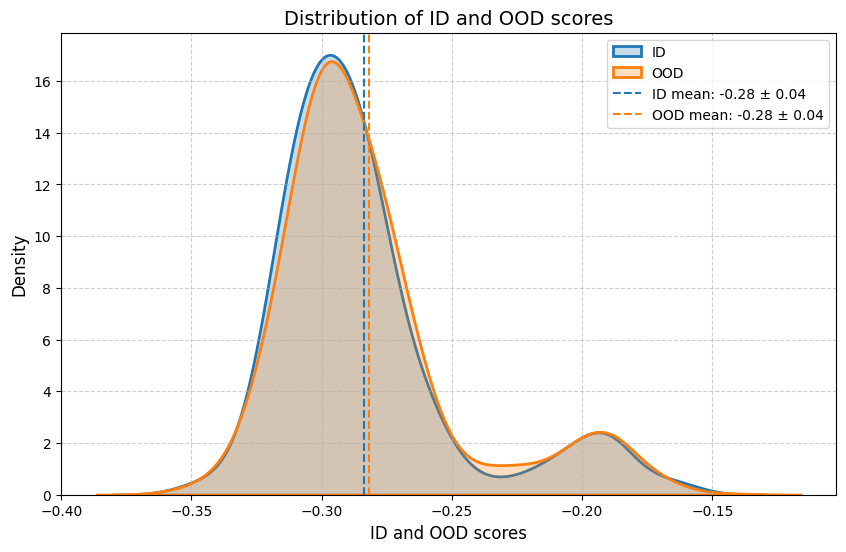

auROC: 0.5217
FPR95: 0.9560
AUC-PR: 0.5151
Optimal Threshold (target_tpr): -0.3227


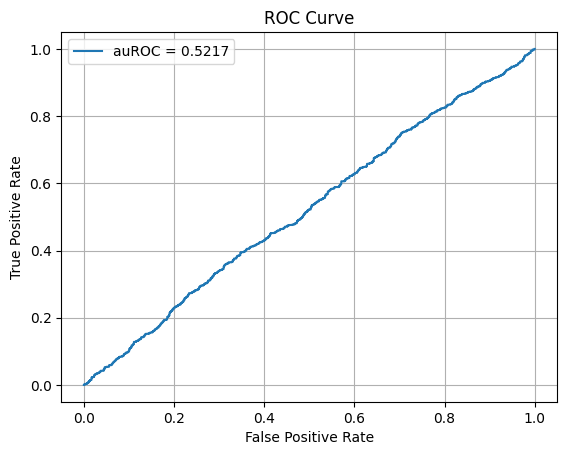

In [41]:
# Plot ID and OOD score distributions 
# -----------------------------------
from src.analysis.visualization import plot_score_distributions_kde, plot_score_distributions_hist
plot_score_distributions_kde(
    scores_id=scores_id,
    scores_ood=scores_ood,
    title="Distribution of ID and OOD scores",
    xlabel="ID and OOD scores"
    #save_path = f"{PLOT_DIR}densities{OUTPUT_TITLE}_k{k}.png"
)

# Compute metrics 
# -----------------------------------
from src.analysis.evaluation import compute_metrics
auroc, fpr95, auc_pr, fpr, tpr, thresholds, selected_threshold = compute_metrics(
    scores_id=scores_id, 
    scores_ood=scores_ood, 
    plot=True,
    threshold_strategy='target_tpr', # 'youden', 'target_tpr'
    target_tpr = 0.95,
    #save_path= f"{PLOT_DIR}roc{OUTPUT_TITLE}_k{k}.png"
)

#### 6.2. Embedding trajectories

Analyse trajectories from 2D embeddings: `avg_emb`, `max_emb`, `last_emb`, `first_gen_emb`, `feat_var_emb`

In [318]:
# Extract 2D scores trajectories (avg_emb, last_emb, first_gen_emb
# max_emb, feat_var_emb)
# -----------------------------------
emb_series = collect_layerwise_series(
    layers=layers,
    id_fit_data=id_fit_data,
    id_test_data=id_test_data,
    od_test_data=od_test_data,
    group='hidden',
    aggregation='last' + '_emb', 
)

**METHOD 1**: Dimension joint volatility of 2D trajectories

In [319]:
# METHOD 1: Compute dimension joint volatility of 2D trajectories
# ----------------------------------
from src.trajectories.trajectories import compute_dimension_joint_volatility_2D

scores_id  = - compute_dimension_joint_volatility_2D(emb_series['id_test'])  ### /.\ I put minus
scores_ood = - compute_dimension_joint_volatility_2D(emb_series['od_test'])  ### /.\ I put minus

print("Mean of ID scores:", np.mean(scores_id))
print("Mean of OOD scores:", np.mean(scores_ood))

Mean of ID scores: -19.486424228679514
Mean of OOD scores: -19.45589837592988


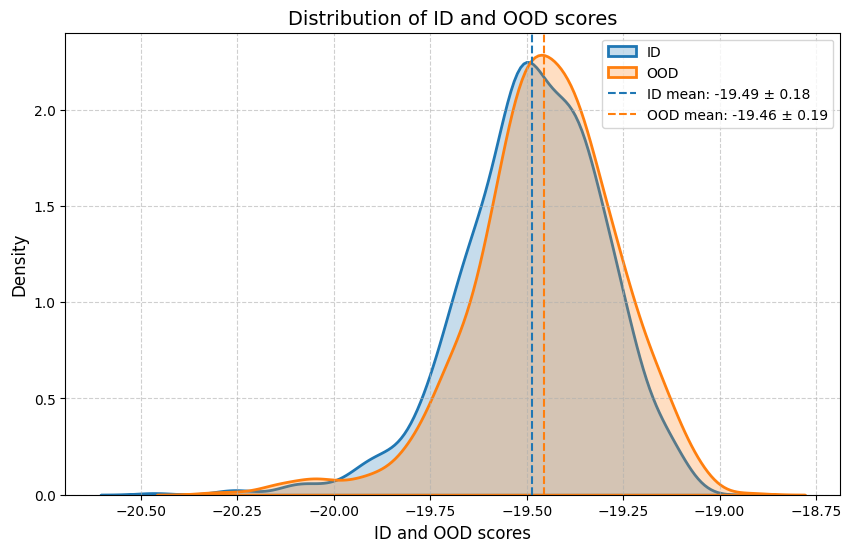

auROC: 0.5493
FPR95: 0.9360
AUC-PR: 0.5535
Optimal Threshold (youden): -19.4511


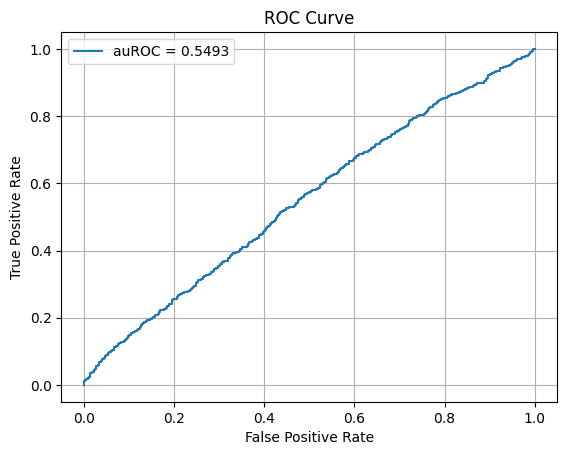

In [320]:
# Plot ID and OOD score distributions 
# -----------------------------------
from src.analysis.visualization import plot_score_distributions_kde, plot_score_distributions_hist
plot_score_distributions_kde(
    scores_id=scores_id,
    scores_ood=scores_ood,
    title="Distribution of ID and OOD scores",
    xlabel="ID and OOD scores"
    #save_path = f"{PLOT_DIR}densities{OUTPUT_TITLE}_k{k}.png"
)

# Compute metrics 
# -----------------------------------
from src.analysis.evaluation import compute_metrics
auroc, fpr95, auc_pr, fpr, tpr, thresholds, selected_threshold = compute_metrics(
    scores_id=scores_id, 
    scores_ood=scores_ood, 
    plot=True,
    threshold_strategy='youden', # 'youden', 'target_tpr'
    target_tpr = 0.95,
    #save_path= f"{PLOT_DIR}roc{OUTPUT_TITLE}_k{k}.png"
)

**METHOD 2**:  Mahalanobis distance of trajectories

In [321]:
# METHOD 2: Compute Mahalanobis distance of trajectories
# -----------------------------------
from src.trajectories.trajectories import compute_id_layer_stats, layerwise_diag_mahalanobis

# 1) ID stats from the *fit* split
mean_LD, var_LD = compute_id_layer_stats(emb_series['id_fit'], eps=1e-10)

# 2) Layerwise diag-Mahalanobis for ID-test and OOD
md_id  = layerwise_diag_mahalanobis(emb_series['id_test'], mean_LD, var_LD)  # (n_id,  L)
md_ood = layerwise_diag_mahalanobis(emb_series['od_test'],  mean_LD, var_LD) # (n_ood, L)

# 3) Trajectory total variation V_j(s)
scores_id  = compute_dimension_joint_volatility_1D(md_id)   # (n_id,)
scores_ood = compute_dimension_joint_volatility_1D(md_ood)  # (n_ood,)

print("Mean of ID scores:", np.mean(scores_id))
print("Mean of OOD scores:", np.mean(scores_ood))

Mean of ID scores: 2.929991432987209
Mean of OOD scores: 2.858320610275983


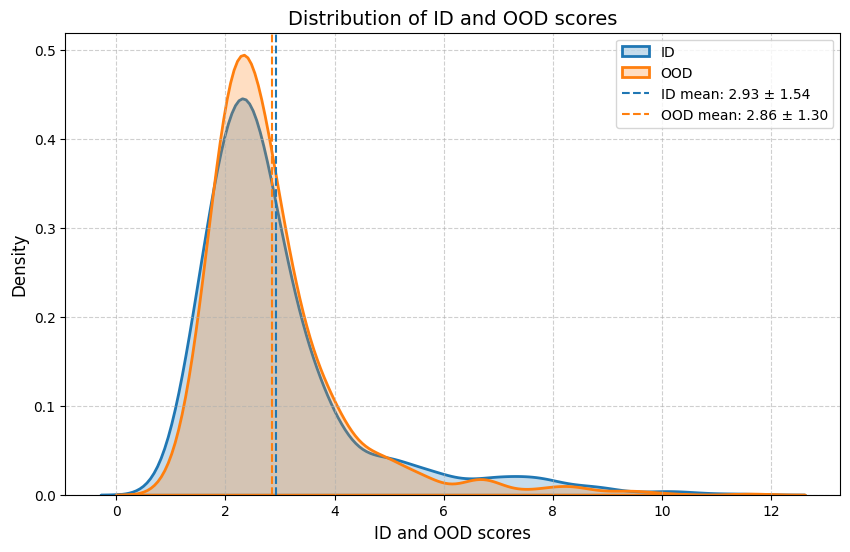

auROC: 0.5093
FPR95: 0.9170
AUC-PR: 0.4923
Optimal Threshold (youden): 1.6780


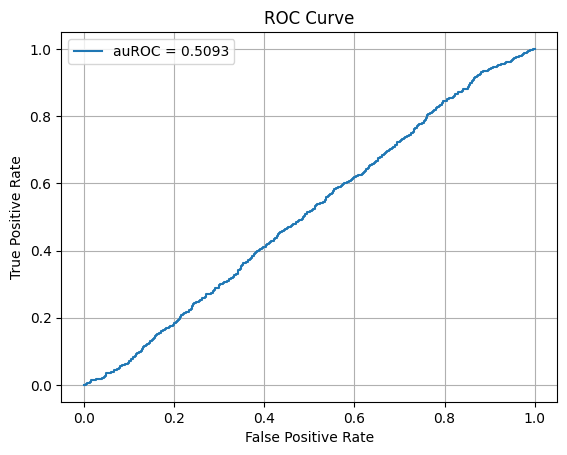

In [322]:
# Plot ID and OOD score distributions 
# -----------------------------------
from src.analysis.visualization import plot_score_distributions_kde, plot_score_distributions_hist
plot_score_distributions_kde(
    scores_id=scores_id,
    scores_ood=scores_ood,
    title="Distribution of ID and OOD scores",
    xlabel="ID and OOD scores"
    #save_path = f"{PLOT_DIR}densities{OUTPUT_TITLE}_k{k}.png"
)

# Compute metrics 
# -----------------------------------
from src.analysis.evaluation import compute_metrics
auroc, fpr95, auc_pr, fpr, tpr, thresholds, selected_threshold = compute_metrics(
    scores_id=scores_id, 
    scores_ood=scores_ood, 
    plot=True,
    threshold_strategy='youden', # 'youden', 'target_tpr'
    target_tpr = 0.95,
    #save_path= f"{PLOT_DIR}roc{OUTPUT_TITLE}_k{k}.png"
)